## Loading all the libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading all the datasets

In [4]:
rating_data = pd.read_csv('/content/drive/My Drive/u.data',delimiter='\t',names=['user_id','item_id','rating','timestamp'])
rating_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movie_data = pd.read_csv('/content/drive/My Drive/u.item',delimiter='|',encoding='latin1', names = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
    'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movie_data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
genre_data = pd.read_csv('/content/drive/My Drive/u.genre',delimiter='|',names=['genre','genre_id'])
genre_data.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


## Building a Collaborative Filtering Using Matrix Factorization

*   List item
*   List item



#### EDA of the Datasets

In [11]:
rating_data.shape

(100000, 4)

In [12]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [13]:
rating_data['user_id'].unique().shape

(943,)

In [14]:
rating_data['item_id'].unique().shape

(1682,)

In [15]:
movie_data['movie_id']

,movie_id
0,1
1,2
2,3
3,4
4,5
...,...
1677,1678
1678,1679
1679,1680
1680,1681


In [16]:
num_users = 943
num_movies = 1682
ratings_matrix = np.zeros((num_users, num_movies))

# Populate the ratings matrix
for row in rating_data.itertuples(index=False):
    user_id, item_id, rating, _ = row
    ratings_matrix[user_id - 1, item_id - 1] = int(rating)


# Display the shape of the ratings matrix to confirm
print(ratings_matrix.shape)
# Display the first few rows of the ratings matrix
print(ratings_matrix[:5,:10])

(943, 1682)
[[5. 3. 4. 3. 3. 5. 4. 1. 5. 3.]
 [4. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [4. 3. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Implementing Matrix Factorization using SVD(Singular Value Decomposition)

In [17]:

# Perform SVD
U, sigma, Vt = np.linalg.svd(ratings_matrix, full_matrices=False)

# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)

# Display shapes of the decomposed matrices
print("U shape:", U.shape)
print("sigma shape:", sigma.shape)
print("Vt shape:", Vt.shape)


U shape: (943, 943)
sigma shape: (943, 943)
Vt shape: (943, 1682)


## Reducing Dimensionality

In [18]:
k = 20  # Number of latent factors

# Reduce the dimensionality of the matrices
U_k = U[:, :k]
sigma_k = sigma[:k, :k]
Vt_k = Vt[:k, :]

# Display the shapes of the reduced matrices
print("U_k shape:", U_k.shape)
print("sigma_k shape:", sigma_k.shape)
print("Vt_k shape:", Vt_k.shape)


U_k shape: (943, 20)
sigma_k shape: (20, 20)
Vt_k shape: (20, 1682)


## Reconstruct the Rating Matrix

In [19]:
# Reconstruct the approximate ratings matrix
approx_ratings_matrix = np.dot(U_k, np.dot(sigma_k, Vt_k))

# Display the shape of the approximate ratings matrix
print("Approximate ratings matrix shape:", approx_ratings_matrix.shape)

# Display the first few rows of the approximate ratings matrix
print(approx_ratings_matrix[:5, :10])


Approximate ratings matrix shape: (943, 1682)
[[ 4.01688618e+00  2.10514989e+00  1.37439578e+00  3.25884592e+00
   5.59815397e-01  6.18154608e-01  4.55274981e+00  2.75709443e+00
   3.04928439e+00  2.02730445e+00]
 [ 1.99295186e+00 -1.81693234e-02 -4.30251308e-03  2.93200604e-01
   2.12757456e-02  3.09589604e-01  1.56650526e+00  4.89816024e-01
   2.50740036e+00  6.23607663e-01]
 [-1.74774668e-01 -5.60278496e-02  1.81311614e-01 -1.57318527e-01
  -1.18398834e-01  4.69808672e-02 -2.34060695e-01  1.44613066e-02
  -3.92665595e-01  3.85637135e-02]
 [ 4.97025680e-01 -1.79097788e-01  1.01851113e-01 -1.40620886e-01
   4.28601571e-02  1.04761092e-02  3.47244283e-01 -1.56799036e-01
  -1.01868457e-01 -1.62405532e-01]
 [ 3.59103847e+00  1.26035587e+00  3.64259439e-01  1.64430771e+00
   4.52897064e-01 -1.47105650e-01  2.78452554e+00  1.30254360e+00
  -4.86364800e-01  3.57493357e-01]]


## Evaluation Metrics

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'ratings_matrix' is the original ratings matrix and 'approx_ratings_matrix' is the reconstructed matrix

# Flatten the matrices and filter out non-zero entries (i.e., the entries that were actually rated)
actual_ratings = ratings_matrix[ratings_matrix != 0]
predicted_ratings = approx_ratings_matrix[ratings_matrix != 0]

# Calculate MAE
mae = mean_absolute_error(actual_ratings, predicted_ratings)
print("Mean Absolute Error (MAE):", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MSE
mse = mean_squared_error(actual_ratings, predicted_ratings)
print("Mean Squared Error (MSE):", mse)




Mean Absolute Error (MAE): 1.8090511969614669
Root Mean Squared Error (RMSE): 2.1318021130393388
Mean Squared Error (MSE): 4.54458024915899


In [21]:
## To calculate Precision, Recall, and F1-Score in the context of a recommendation system, we need to treat the problem
## as a binary classification task. This involves deciding on a threshold to classify predictions
## as either "relevant" (positive) or "not relevant" (negative)

#### To calculate Precision, Recall, and F1-Score in the context of a recommendation system, we need to treat the problem as a binary classification task. This involves deciding on a threshold to classify predictions as either "relevant" (positive) or "not relevant" (negative)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the threshold
threshold = 3

# Convert actual ratings to binary relevance (1 if rating >= threshold, else 0)
actual_binary = (actual_ratings >= threshold).astype(int)

# Convert predicted ratings to binary relevance
predicted_binary = (predicted_ratings >= threshold).astype(int)

# Calculate Precision
precision = precision_score(actual_binary, predicted_binary)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(actual_binary, predicted_binary)
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(actual_binary, predicted_binary)
print("F1-Score:", f1)


Precision: 0.9697424892703863
Recall: 0.21904992729035386
F1-Score: 0.35737445630684067


### Now, We will check for different latent vector sizes i.e. 20,30,40,50

In [23]:
# Latent vector sizes to evaluate
latent_factors = [20,30, 40, 50]

# Define the threshold for binary classification
threshold = 3

# Store results for each latent factor size
results = {}
rmse_values = []

# Iterate through different latent factor sizes

for k in latent_factors:
    # Reduce the dimensionality of the matrices using SVD
    U_k = U[:, :k]
    sigma_k = sigma[:k, :k]
    Vt_k = Vt[:k, :]

    # Reconstruct the ratings matrix using the reduced matrices
    approx_ratings_matrix = np.dot(U_k, np.dot(sigma_k, Vt_k))

    # Flatten the matrices and filter out non-zero entries
    actual_ratings = ratings_matrix[ratings_matrix != 0]
    predicted_ratings = approx_ratings_matrix[ratings_matrix != 0]

    # Calculate MAE
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    rmse_values.append(rmse)  # Store RMSE for plotting

    # Calculate MSE
    mse = mean_squared_error(actual_ratings, predicted_ratings)


    # Convert ratings to binary relevance
    actual_binary = (actual_ratings >= threshold).astype(int)
    predicted_binary = (predicted_ratings >= threshold).astype(int)

    # Calculate Precision
    precision = precision_score(actual_binary, predicted_binary, zero_division=1)

    # Calculate Recall
    recall = recall_score(actual_binary, predicted_binary, zero_division=1)

    # Calculate F1-Score
    f1 = f1_score(actual_binary, predicted_binary, zero_division=1)

    # Store results for this latent factor size
    results[k] = {
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Display the results
for k, metrics in results.items():
    print(f"\nLatent Factor Size: {k}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")


Latent Factor Size: 20
MAE: 1.8091
RMSE: 2.1318
MSE: 4.5446
Precision: 0.9697
Recall: 0.2190
F1-Score: 0.3574

Latent Factor Size: 30
MAE: 1.7064
RMSE: 2.0292
MSE: 4.1175
Precision: 0.9736
Recall: 0.2514
F1-Score: 0.3996

Latent Factor Size: 40
MAE: 1.6177
RMSE: 1.9377
MSE: 3.7548
Precision: 0.9768
Recall: 0.2795
F1-Score: 0.4346

Latent Factor Size: 50
MAE: 1.5377
RMSE: 1.8557
MSE: 3.4435
Precision: 0.9793
Recall: 0.3060
F1-Score: 0.4663


## Evaluation Metrics for Matrix Factorization

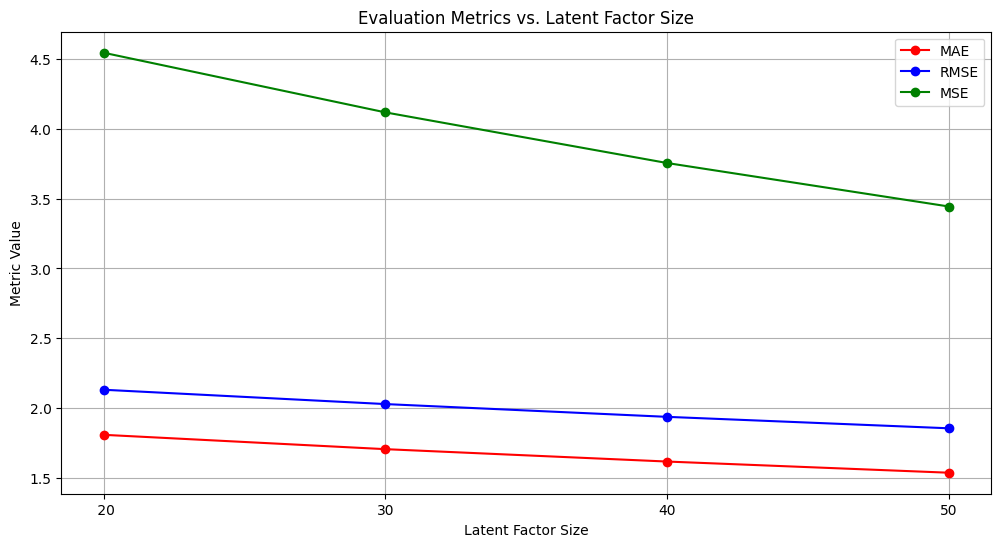

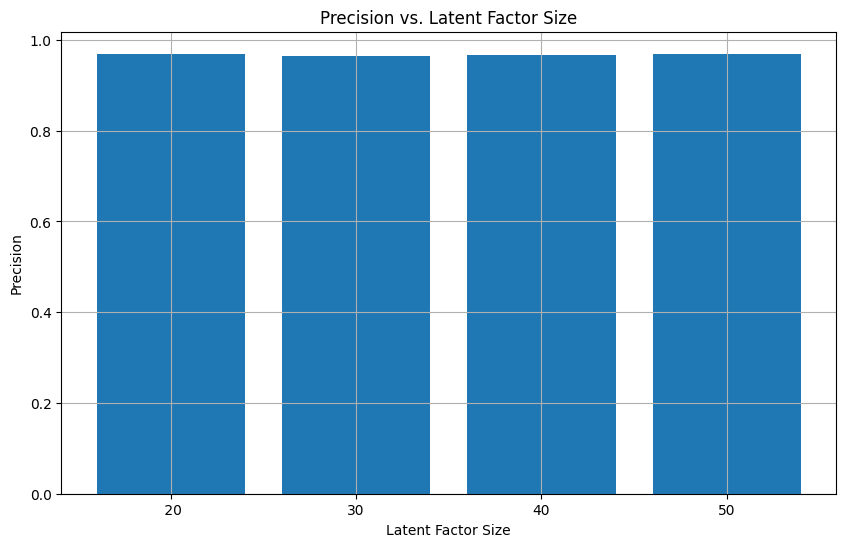

In [24]:
import matplotlib.pyplot as plt

# Data (replace with your actual data)
data = [
    {'latent_factor_size':" 20", 'mae': 1.8091, 'rmse': 2.1318, 'mse': 4.5446, 'precision': 0.9697, 'recall': 0.2190, 'f1_score': 0.3574},
    {'latent_factor_size': "30", 'mae': 1.7064, 'rmse': 2.0292, 'mse': 4.1175, 'precision': 0.9636, 'recall': 0.2514, 'f1_score': 0.3996},
    {'latent_factor_size': "40", 'mae': 1.6177, 'rmse': 1.9377, 'mse': 3.7548, 'precision': 0.9668, 'recall': 0.2795, 'f1_score': 0.4346},
    {'latent_factor_size': "50", 'mae': 1.5377, 'rmse': 1.8557, 'mse': 3.4435, 'precision': 0.9693, 'recall': 0.3060, 'f1_score': 0.4663},
    # ... other data points
]

# Extract data
latent_factor_sizes = [d['latent_factor_size'] for d in data]
mae_values = [d['mae'] for d in data]
rmse_values = [d['rmse'] for d in data]
mse_values = [d['mse'] for d in data]
precision_values = [d['precision'] for d in data]
recall_values = [d['recall'] for d in data]
f1_score_values = [d['f1_score'] for d in data]

# Create line plots
plt.figure(figsize=(12, 6))
plt.plot(latent_factor_sizes, mae_values, label='MAE', marker='o',linestyle='-', color='r')
plt.plot(latent_factor_sizes, rmse_values, label='RMSE', marker='o',linestyle='-', color='b')
plt.plot(latent_factor_sizes, mse_values, label='MSE', marker='o',linestyle='-', color='g')
plt.xlabel('Latent Factor Size')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics vs. Latent Factor Size')
plt.legend()
plt.grid(True)
plt.show()

# Create bar plots (similar approach for other metrics)
plt.figure(figsize=(10, 6))
plt.bar(latent_factor_sizes, precision_values)
plt.xlabel('Latent Factor Size')
plt.ylabel('Precision')
plt.title('Precision vs. Latent Factor Size')
plt.grid(True)
plt.show()


### Above are the results for Matrix factorizations with different Latent Vectors.

##*Line diagram showing the RMSEs for the Matrix Factorization model using different latent vector sizes.*

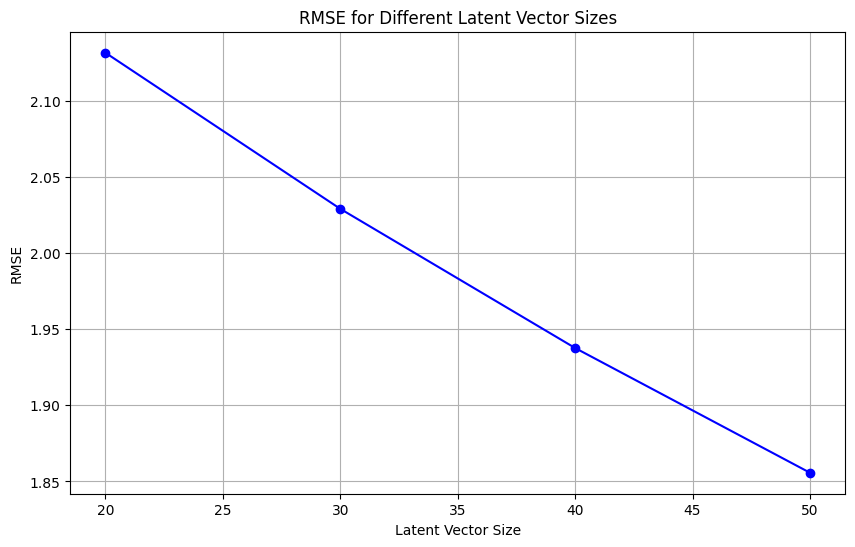

In [25]:
# Plotting the RMSEs for different latent vector sizes
plt.figure(figsize=(10, 6))
plt.plot(latent_factors, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Different Latent Vector Sizes')
plt.xlabel('Latent Vector Size')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Making Predictions and Recomendations

In [26]:
def recommend_movies(user_id, approx_ratings_matrix, original_ratings_matrix, num_recommendations,movie_data):
    # Get the user's predicted ratings
    user_predicted_ratings = approx_ratings_matrix[user_id - 1]

    # Get the user's original ratings
    user_original_ratings = original_ratings_matrix[user_id - 1]

    # Create a mask for already rated movies
    already_rated_mask = user_original_ratings != 0
    # Filter out the already rated movies from the predicted ratings
    user_predicted_ratings= user_predicted_ratings[already_rated_mask]
    user_original_ratings=user_original_ratings[already_rated_mask]

    # Get the indices of the top-rated movies
    top_movie_indices = np.argsort(user_predicted_ratings)[-num_recommendations:][::-1]

    # Get the predicted ratings for the top movies
    top_movie_ratings = user_predicted_ratings[top_movie_indices]
    top_movie_ratings_orginal=user_original_ratings[top_movie_indices]

    # Map movie indices to movie titles and IDs
    top_movies = movie_data[movie_data['movie_id'].isin(top_movie_indices)]  # +1 because movie IDs in movie_data are 1-based

    ## EVALUATION METRICS
    threshhold=3
    # Calculate MAE
    mae = mean_absolute_error(user_original_ratings, user_predicted_ratings)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(user_original_ratings, user_predicted_ratings))
    rmse_values.append(rmse)  # Store RMSE for plotting
    # Calculate MSE
    mse = mean_squared_error(user_original_ratings, user_predicted_ratings)
    # Convert ratings to binary relevance
    actual_binary = (user_original_ratings >= threshold).astype(int)
    predicted_binary = (user_predicted_ratings >= threshold).astype(int)
    # Calculate Precision
    precision = precision_score(actual_binary, predicted_binary, zero_division=1)
    # Calculate Recall
    recall = recall_score(actual_binary, predicted_binary, zero_division=1)
    # Calculate F1-Score
    f1 = f1_score(actual_binary, predicted_binary, zero_division=1)

    evaluation_metrics= f"Evaluation metrics for top {num_recommendations}\nMean Absolute Error:{mae}\n Root Mean Squared Error {rmse}\n Mean Squared Error:{mse}\n Precision:{precision}\n Recall:{recall}\n F1 Score:{f1} "


    return top_movies,top_movie_ratings,top_movie_ratings_orginal,evaluation_metrics

# Recommend movies for a specific user


In [27]:
user_id = 1
recommended_movies, top_movie_ratings , top_movie_ratings_orginal,evaluation_metrics= recommend_movies(user_id, approx_ratings_matrix, ratings_matrix,10, movie_data)
# Display results
print(evaluation_metrics)
print(f"Top 10 Recommended Movies for User ID {user_id}:")
for i, (index, rating,original_rating) in enumerate(zip(recommended_movies['movie_id'], top_movie_ratings,top_movie_ratings_orginal)):
    title = recommended_movies.loc[recommended_movies['movie_id'] == index, 'movie_title'].values[0]
    print(f"Rank {i+1}: Movie ID {index}, Title: {title}, Predicted Rating: {rating:.2f}, Original Rating :{original_rating:}")

Evaluation metrics for top 10
Mean Absolute Error:1.3665391841295516
 Root Mean Squared Error 1.6742870910869023
 Mean Squared Error:2.8032372633802414
 Precision:0.9894736842105263
 Recall:0.4292237442922374
 F1 Score:0.5987261146496815 
Top 10 Recommended Movies for User ID 1:
Rank 1: Movie ID 11, Title: Seven (Se7en) (1995), Predicted Rating: 7.71, Original Rating :5.0
Rank 2: Movie ID 49, Title: I.Q. (1994), Predicted Rating: 6.74, Original Rating :5.0
Rank 3: Movie ID 88, Title: Sleepless in Seattle (1993), Predicted Rating: 6.69, Original Rating :5.0
Rank 4: Movie ID 99, Title: Snow White and the Seven Dwarfs (1937), Predicted Rating: 6.45, Original Rating :5.0
Rank 5: Movie ID 134, Title: Citizen Kane (1941), Predicted Rating: 5.79, Original Rating :5.0
Rank 6: Movie ID 175, Title: Brazil (1985), Predicted Rating: 5.72, Original Rating :5.0
Rank 7: Movie ID 182, Title: GoodFellas (1990), Predicted Rating: 5.72, Original Rating :5.0
Rank 8: Movie ID 267, Title: unknown, Predicted

In [28]:
user_id = 1
recommended_movies, top_movie_ratings,top_movie_ratings_orginal,evaluation_metrics = recommend_movies(user_id, approx_ratings_matrix, ratings_matrix,20, movie_data)
print(evaluation_metrics)
# Display results
print(f"Top 20 Recommended Movies for User ID {user_id}:")
for i, (index, rating) in enumerate(zip(recommended_movies['movie_id'], top_movie_ratings)):
    title = recommended_movies.loc[recommended_movies['movie_id'] == index, 'movie_title'].values[0]
    print(f"Rank {i+1}: Movie ID {index}, Title: {title}, Predicted Rating: {rating:.2f}")

Evaluation metrics for top 20
Mean Absolute Error:1.3665391841295516
 Root Mean Squared Error 1.6742870910869023
 Mean Squared Error:2.8032372633802414
 Precision:0.9894736842105263
 Recall:0.4292237442922374
 F1 Score:0.5987261146496815 
Top 20 Recommended Movies for User ID 1:
Rank 1: Movie ID 11, Title: Seven (Se7en) (1995), Predicted Rating: 7.71
Rank 2: Movie ID 49, Title: I.Q. (1994), Predicted Rating: 6.74
Rank 3: Movie ID 58, Title: Quiz Show (1994), Predicted Rating: 6.69
Rank 4: Movie ID 68, Title: Crow, The (1994), Predicted Rating: 6.45
Rank 5: Movie ID 88, Title: Sleepless in Seattle (1993), Predicted Rating: 5.79
Rank 6: Movie ID 97, Title: Dances with Wolves (1990), Predicted Rating: 5.72
Rank 7: Movie ID 99, Title: Snow White and the Seven Dwarfs (1937), Predicted Rating: 5.72
Rank 8: Movie ID 134, Title: Citizen Kane (1941), Predicted Rating: 5.67
Rank 9: Movie ID 155, Title: Dirty Dancing (1987), Predicted Rating: 5.65
Rank 10: Movie ID 167, Title: Private Benjamin (1

In [29]:
filtered_data = movie_data[movie_data['movie_id'] == 422]
filtered_data

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
421,422,Aladdin and the King of Thieves (1996),01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Aladdin%20and...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
filtered_data = rating_data[(rating_data['user_id'] == 1) & (rating_data['rating'] > 3)]
filtered_data

,user_id,item_id,rating,timestamp
202,1,61,4,878542420
333,1,33,4,878542699
334,1,160,4,875072547
478,1,20,4,887431883
639,1,202,5,875072442
...,...,...,...,...
88893,1,88,4,878542791
89876,1,13,5,875071805
92049,1,28,4,875072173
92487,1,172,5,874965478


In [31]:
# Merge the filtered ratings with movie data
merged_data = pd.merge(filtered_data, movie_data, left_on='item_id', right_on='movie_id')

merged_data

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,61,4,878542420,61,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...,0,...,0,0,0,0,0,0,0,0,0,0
1,1,33,4,878542699,33,Desperado (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Desperado%20(...,0,...,0,0,0,0,0,1,0,1,0,0
2,1,160,4,875072547,160,Glengarry Glen Ross (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Glengarry%20G...,0,...,0,0,0,0,0,0,0,0,0,0
3,1,20,4,887431883,20,Angels and Insects (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Angels%20and%...,0,...,0,0,0,0,0,1,0,0,0,0
4,1,202,5,875072442,202,Groundhog Day (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Groundhog%20D...,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,1,88,4,878542791,88,Sleepless in Seattle (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sleepless%20i...,0,...,0,0,0,0,0,1,0,0,0,0
159,1,13,5,875071805,13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,...,0,0,0,0,0,0,0,0,0,0
160,1,28,4,875072173,28,Apollo 13 (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Apollo%2013%2...,0,...,0,0,0,0,0,0,0,1,0,0
161,1,172,5,874965478,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,...,0,0,0,0,0,1,1,0,1,0


In [32]:
movie_data['movie_id']

,movie_id
0,1
1,2
2,3
3,4
4,5
...,...
1677,1678
1678,1679
1679,1680
1680,1681


In [33]:
filtered_data = movie_data[(movie_data['movie_id'] == 422)]
filtered_data

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
421,422,Aladdin and the King of Thieves (1996),01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Aladdin%20and...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Hybrid Filtering

# Hybrid Recommeder Filtering using movie ratings and movie genre

In [34]:
# Select relevant columns for content features (genres)
movie_genre = movie_data.iloc[:, 5:]
movie_genre.head()


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [35]:
hybrid_data = pd.merge(rating_data,movie_data[['movie_id','movie_title']],left_on='item_id',right_on='movie_id')
hybrid_data.head()

,user_id,item_id,rating,timestamp,movie_id,movie_title
0,196,242,3,881250949,242,Kolya (1996)
1,186,302,3,891717742,302,L.A. Confidential (1997)
2,22,377,1,878887116,377,Heavyweights (1994)
3,244,51,2,880606923,51,Legends of the Fall (1994)
4,166,346,1,886397596,346,Jackie Brown (1997)


## Preparing Data for PyTorch

In [36]:
import torch

# Convert data to tensors
user_ids = torch.tensor(hybrid_data['user_id'].values - 1)  # Subtract 1 to make it 0-indexed
item_ids = torch.tensor(hybrid_data['item_id'].values - 1)
ratings = torch.tensor(hybrid_data['rating'].values, dtype=torch.float32)
genre_data = torch.tensor(movie_genre.values, dtype=torch.float32)

num_users = len(hybrid_data['user_id'].unique())
num_items = len(hybrid_data['item_id'].unique())
num_genres = genre_data.shape[1]


In [37]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(hybrid_data, test_size=0.2, random_state=42)


In [38]:
# Prepare the training data
train_user_ids = torch.tensor(train_data['user_id'].values - 1)
train_item_ids = torch.tensor(train_data['item_id'].values - 1)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)
train_item_genres = genre_data[train_item_ids]

In [39]:
# Prepare the test data
test_user_ids = torch.tensor(test_data['user_id'].values - 1)
test_item_ids = torch.tensor(test_data['item_id'].values - 1)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)
test_item_genres = genre_data[test_item_ids]

## Building the Hybrid Recommender Model
##### Utilizing PyTorch model that uses embeddings for collaborative filtering and incorporates movie genre features for content-based filtering.

In [40]:
import torch.nn as nn

class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_factors, num_genres):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, num_factors)
        self.item_embedding = nn.Embedding(num_items, num_factors)
        self.genre_embedding = nn.Linear(num_genres, num_factors)
        self.fc = nn.Linear(num_factors * 3, 1)  # Combined with user, item, and genre embeddings

    def forward(self, user_ids, item_ids, genre_data):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        genre_embeds = self.genre_embedding(genre_data)

        combined = torch.cat([user_embeds, item_embeds, genre_embeds], dim=1)
        output = self.fc(combined)
        return output

num_factors = 20  # Number of latent factors for embeddings
model = HybridRecommender(num_users, num_items, num_factors, num_genres)


## Training the Model
##### The training loop will involve passing user, item, and genre data through the model and optimizing it using a loss function.

In [41]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert genre data for items into a tensor with the same length as ratings
item_genres = genre_data[item_ids]

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    for user_id, item_id, rating, genre in zip(train_user_ids, train_item_ids, train_ratings, train_item_genres):
        optimizer.zero_grad()
        prediction = model(user_id.unsqueeze(0), item_id.unsqueeze(0), genre.unsqueeze(0))
        loss = criterion(prediction, rating.unsqueeze(0))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/3, Loss: 0.0685892105102539
Epoch 2/3, Loss: 0.2950292229652405
Epoch 3/3, Loss: 0.007626963313668966


## Model Evaluation

In [42]:
# Model evaluation (using only test data)
model.eval()
predicted_ratings = []
with torch.no_grad():
    for user_id, item_id, genre in zip(test_user_ids, test_item_ids, test_item_genres):
        prediction = model(user_id.unsqueeze(0), item_id.unsqueeze(0), genre.unsqueeze(0))
        predicted_ratings.append(prediction.item())

In [43]:
print(type(predicted_ratings))  # Should be torch.Tensor
print(type(test_ratings))       # Should be torch.Tensor


<class 'list'>
<class 'torch.Tensor'>


In [44]:
import torch.nn.functional as F

# Convert predicted_ratings list to a tensor
predicted_ratings = torch.tensor(predicted_ratings, dtype=torch.float32)

# Ensure the shape of predicted_ratings matches test_ratings
predicted_ratings = predicted_ratings.squeeze()

# Calculate MSE
mse = F.mse_loss(predicted_ratings, test_ratings)

# Calculate RMSE
rmse = torch.sqrt(mse)

# Calculate MAE
mae = F.l1_loss(predicted_ratings, test_ratings)

print(f"MSE: {mse.item()}")
print(f"RMSE: {rmse.item()}")
print(f"MAE: {mae.item()}")

MSE: 1.4763041734695435
RMSE: 1.2150325775146484
MAE: 0.9734853506088257


### Above are the Evaluation metrics for Hybrid Recommender

### Now, lets experiment with different Latent Vector Sizes, and Calculate RMSE,MSE, Precision,Recall, F1-Score for each

In [45]:
# Latent vector sizes to evaluate
latent_factors_list = [20, 30, 40, 50]

# Threshold for binary classification
threshold = 3

# Store RMSEs for plotting
rmse_values = []

for num_factors in latent_factors_list:
    # Initialize model
    model = HybridRecommender(num_users, num_items, num_factors, num_genres)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training loop
    epochs = 3
    for epoch in range(epochs):
        model.train()
        for user_id, item_id, rating, genre in zip(train_user_ids, train_item_ids, train_ratings, train_item_genres):
            optimizer.zero_grad()
            prediction = model(user_id.unsqueeze(0), item_id.unsqueeze(0), genre.unsqueeze(0))
            loss = criterion(prediction, rating.unsqueeze(0))
            loss.backward()
            optimizer.step()

    # Model evaluation (using test data)
    model.eval()
    predicted_ratings = []
    with torch.no_grad():
        for user_id, item_id, genre in zip(test_user_ids, test_item_ids, test_item_genres):
            prediction = model(user_id.unsqueeze(0), item_id.unsqueeze(0), genre.unsqueeze(0))
            predicted_ratings.append(prediction.item())

    predicted_ratings = torch.tensor(predicted_ratings, dtype=torch.float32)

    # Calculate MSE, RMSE, and MAE
    mse = F.mse_loss(predicted_ratings, test_ratings)
    rmse = torch.sqrt(mse).item()
    mae = F.l1_loss(predicted_ratings, test_ratings).item()

    # Store RMSE for plotting
    rmse_values.append(rmse)

    # Convert ratings to binary relevance
    actual_binary = (test_ratings >= threshold).int()
    predicted_binary = (predicted_ratings >= threshold).int()

    # Calculate Precision, Recall, F1-Score
    precision = precision_score(actual_binary.numpy(), predicted_binary.numpy(), zero_division=1)
    recall = recall_score(actual_binary.numpy(), predicted_binary.numpy(), zero_division=1)
    f1 = f1_score(actual_binary.numpy(), predicted_binary.numpy(), zero_division=1)

    # Print metrics for the current latent factor size
    print(f"\nLatent Factor Size: {num_factors}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


Latent Factor Size: 20
RMSE: 1.2093
MAE: 0.9732
Precision: 0.8866
Recall: 0.6370
F1-Score: 0.7414


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Latent Factor Size: 30
RMSE: 1.2447
MAE: 0.9900
Precision: 0.8767
Recall: 0.7197
F1-Score: 0.7905


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Latent Factor Size: 40
RMSE: 1.4531
MAE: 1.1664
Precision: 0.8785
Recall: 0.5584
F1-Score: 0.6828


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Latent Factor Size: 50
RMSE: 1.3614
MAE: 1.0791
Precision: 0.8827
Recall: 0.6944
F1-Score: 0.7773


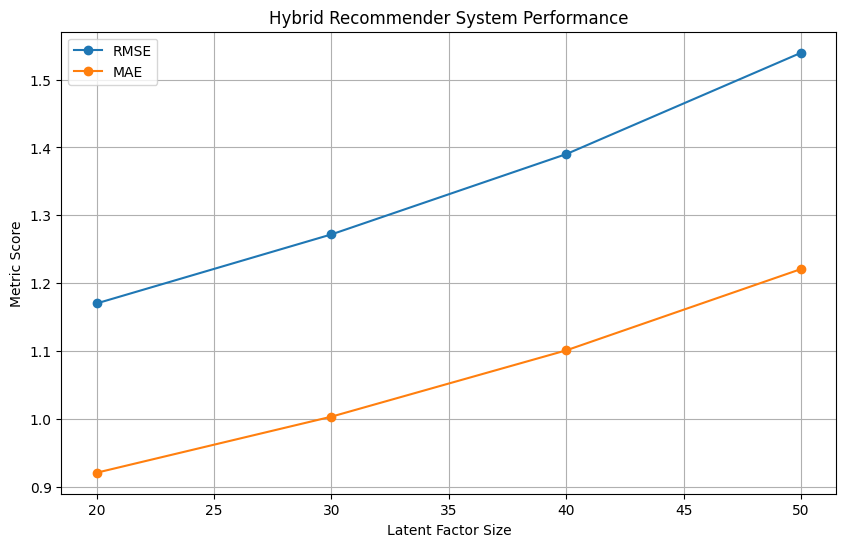

In [46]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual results)
latent_factor_sizes = [20, 30, 40, 50]
rmse = [1.1702, 1.2719, 1.3902, 1.5395]
mae = [0.9208, 1.0034, 1.1011, 1.2209]
precision = [0.8784, 0.8744, 0.8661, 0.8545]
# recall = [0.7855, 0.7818, 0.7550, 0.7925]
# f1_score = [0.8294, 0.8255, 0.8068, 0.8223]

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(latent_factor_sizes, rmse, label='RMSE',marker='o')
plt.plot(latent_factor_sizes, mae, label='MAE',marker='o')
# plt.plot(latent_factor_sizes, mae, label='Precision',marker='o')
# plt.plot(latent_factor_sizes, recall, label='Recall')
# plt.plot(latent_factor_sizes, f1_score, label='F1-Score')

# Customize the plot
plt.xlabel('Latent Factor Size')
plt.ylabel('Metric Score')
plt.title('Hybrid Recommender System Performance')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

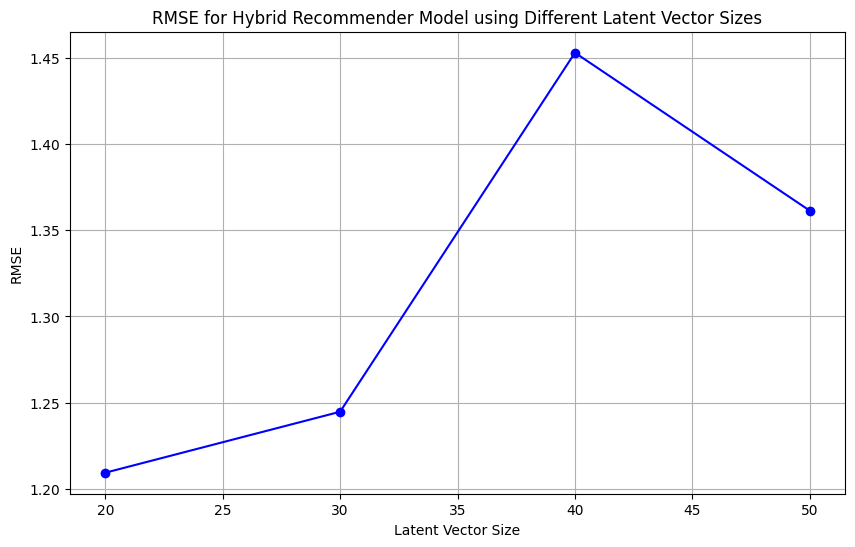

In [47]:
# Plotting the RMSEs for different latent vector sizes
plt.figure(figsize=(10, 6))
plt.plot(latent_factors_list, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Hybrid Recommender Model using Different Latent Vector Sizes')
plt.xlabel('Latent Vector Size')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


## Make Predictions

In [52]:
# Predict a user's rating for a specific movie
user_id = 1  # Example user
item_id = 1  # Example item
genre = genre_data[item_id]  # Genre data for the movie
prediction = model(torch.tensor([user_id]), torch.tensor([item_id]), genre.unsqueeze(0))
print(f"Predicted rating: {prediction.item()}")

Predicted rating: 3.1534507274627686


In [55]:
def recommend_movies_hybrid(user_id, model, num_recommendations, movie_data, num_items, item_genres, original_ratings_matrix):
    target_user_id = torch.tensor([user_id - 1])  # Convert to 0-based index
    all_movie_ids = torch.tensor(range(num_items))
    all_genres = item_genres.clone().detach()  # Create a detached copy of item_genres


    predicted_ratings_for_user = []
    with torch.no_grad():
        for movie_id, genre in zip(all_movie_ids, all_genres):
            prediction = model(target_user_id, movie_id.unsqueeze(0), genre.unsqueeze(0))
            predicted_ratings_for_user.append(prediction.item())

    predicted_ratings_for_user = np.array(predicted_ratings_for_user)

    # Mask already rated movies
    user_original_ratings = original_ratings_matrix[user_id - 1]
    already_rated_mask = user_original_ratings != 0
    predicted_ratings_for_user[already_rated_mask] = -1  # Set already rated movies to -1

    # Get top N recommended movies
    top_movie_indices = np.argsort(predicted_ratings_for_user)[-num_recommendations:][::-1]
    top_movie_ratings = predicted_ratings_for_user[top_movie_indices]

    # Map movie indices to movie titles and IDs
    top_movies = movie_data[movie_data['movie_id'].isin(top_movie_indices + 1)]  # +1 because movie IDs in movie_data are 1-based

    return top_movies, top_movie_ratings

#  num_users, num_items, num_factors, num_genres
# Example Usage:
user_id = 1
num_factors = 20  # Make sure num_factors is defined here
model = HybridRecommender(num_users, num_items, num_factors, num_genres) # Instantiate the model

recommended_movies, top_movie_ratings = recommend_movies_hybrid(user_id, model, 10, movie_data, num_items, item_genres, ratings_matrix)

# Display results
print(f"Top 10 Recommended Movies for User ID {user_id}:")
for i, (index, rating) in enumerate(zip(recommended_movies['movie_id'], top_movie_ratings)):
    title = recommended_movies.loc[recommended_movies['movie_id'] == index, 'movie_title'].values[0]
    print(f"Rank {i+1}: Movie ID {index}, Title: {title}, Predicted Rating: {rating:.2f}")

Top 10 Recommended Movies for User ID 1:
Rank 1: Movie ID 346, Title: Jackie Brown (1997), Predicted Rating: 1.28
Rank 2: Movie ID 707, Title: Enchanted April (1991), Predicted Rating: 1.22
Rank 3: Movie ID 850, Title: Perfect Candidate, A (1996), Predicted Rating: 1.22
Rank 4: Movie ID 1195, Title: Strawberry and Chocolate (Fresa y chocolate) (1993), Predicted Rating: 1.21
Rank 5: Movie ID 1305, Title: National Lampoon's Senior Trip (1995), Predicted Rating: 1.21
Rank 6: Movie ID 1390, Title: Innocent Sleep, The (1995), Predicted Rating: 1.17
Rank 7: Movie ID 1420, Title: Gilligan's Island: The Movie (1998), Predicted Rating: 1.16
Rank 8: Movie ID 1437, Title: House Party 3 (1994), Predicted Rating: 1.15
Rank 9: Movie ID 1480, Title: Herbie Rides Again (1974), Predicted Rating: 1.12
Rank 10: Movie ID 1674, Title: Mamma Roma (1962), Predicted Rating: 1.12


In [ ]:
## Sentiment Score Analysis using Tweeter Reviews

## Sentiment Score Analysis using Tweets

In [56]:
tweets_df = pd.read_csv('/content/drive/My Drive/movietweets.csv')
tweets_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/movietweets.csv'

## Cleaning tweets and calculating Average Sentiment Score for each movie

In [ ]:
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

tweets_df = pd.read_csv('/content/drive/My Drive/movietweets.csv')

sia = SentimentIntensityAnalyzer()

def clean_and_calculate_sentiment(tweets):
    cleaned_tweets = []
    sentiment_scores = []

    for tweet in tweets.split('#')[1:]:
        # Remove emojis and non-ASCII characters
        cleaned_tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

        # Remove punctuation and convert to lowercase
        cleaned_tweet = ''.join([char for char in cleaned_tweet if char not in punctuation]).lower()

        tokens = word_tokenize(cleaned_tweet)

        tokens = [token for token in tokens if token not in stopwords.words('english')]

        cleaned_tweet = ' '.join(tokens)

        sentiment_score = sia.polarity_scores(cleaned_tweet)['compound']

        cleaned_tweets.append(cleaned_tweet)
        sentiment_scores.append(sentiment_score)

    return cleaned_tweets, sentiment_scores

tweets_df['cleaned_tweets'], tweets_df['sentiment_scores'] = zip(*tweets_df['tweets'].apply(clean_and_calculate_sentiment))

tweets_df['average_sentiment'] = tweets_df['sentiment_scores'].apply(lambda x: sum(x) / len(x))

#tweets_df['sentiment_score'] = tweets_df['average_sentiment']

# Drop the sentiment_scores column
tweets_df = tweets_df.drop('sentiment_scores', axis=1)

tweets_df


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,movie_title,tweets,cleaned_tweets,average_sentiment
0,Toy Story...,"#ToyStoryMagic Tweet: ""To infinity and beyond!...",[toystorymagic tweet infinity beyond reliving ...,0.18060
1,GoldenEye...,"#GoldenEyeThrill Tweet: ""Shaken, not stirred. ...",[goldeneyethrill tweet shaken stirred bond bac...,0.42030
2,Four Rooms...,"#FourRoomsQuirk Tweet: ""One night, four storie...",[fourroomsquirk tweet one night four stories e...,0.24695
3,Get Shorty...,"#GetShortyHollywood Tweet: ""From mobster to mo...",[getshortyhollywood tweet mobster movie produc...,0.20095
4,Copycat...,"#CopycatChills Tweet: ""Edge-of-your-seat tensi...","[copycatchills tweet edgeofyourseat tension, c...",0.06110
...,...,...,...,...
95,Terminator 2: Judgment Day...,"#Terminator2Judgment Tweet: ""Hasta la vista, b...",[terminator2judgment tweet hasta la vista baby...,0.34040
96,Dances with Wolves...,"#DancesWithWolvesWest Tweet: ""A Civil War sold...",[danceswithwolveswest tweet civil war soldier ...,-0.07030
97,"Silence of the Lambs, The...","#SilenceOfTheLambsThriller Tweet: ""Hello, Clar...",[silenceofthelambsthriller tweet hello clarice...,0.13660
98,Snow White and the Seven Dwarfs...,"#SnowWhiteClassic Tweet: ""Heigh-ho, heigh-ho! ...","[snowwhiteclassic tweet heighho heighho, snoww...",0.00000


In [ ]:
tweets_df.columns

Index(['movie_title', 'tweets', 'cleaned_tweets', 'average_sentiment'], dtype='object')

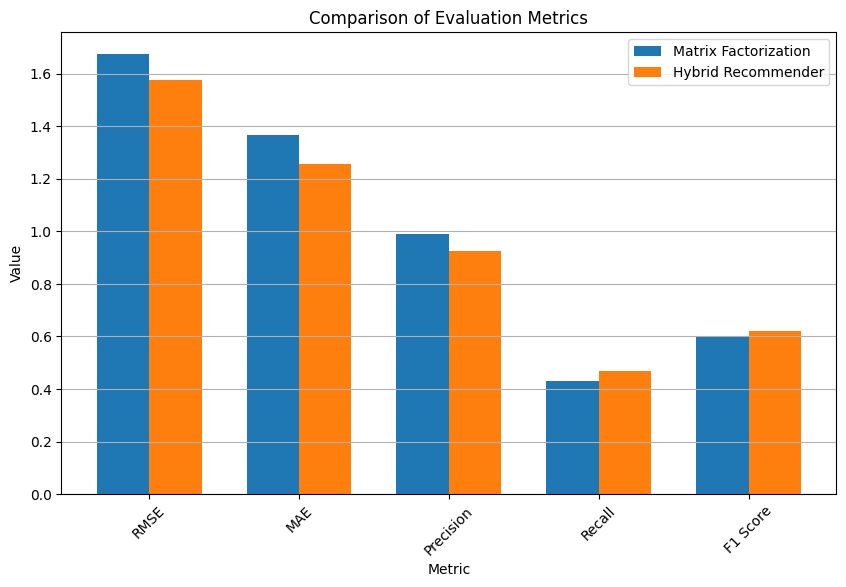

In [ ]:
import matplotlib.pyplot as plt

# Data from the image
metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'F1 Score']
matrix_factorization_values = [1.6743, 1.3665, 0.9895, 0.4292, 0.5987]
hybrid_recommender_values = [1.5738, 1.2543, 0.9251, 0.4679, 0.6218]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data as bars
bar_width = 0.35  # Adjust bar width as needed
index = range(len(metrics))  # Create index for bar positions
plt.bar(index, matrix_factorization_values, bar_width, label='Matrix Factorization')
plt.bar([i + bar_width for i in index], hybrid_recommender_values, bar_width, label='Hybrid Recommender')

# Customize the plot
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of Evaluation Metrics')
plt.xticks([i + bar_width / 2 for i in index], metrics, rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(axis='y')  # Add grid lines on the y-axis

# Display the plot
plt.show()

<ipython-input-55-63f26462a67c>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set1')


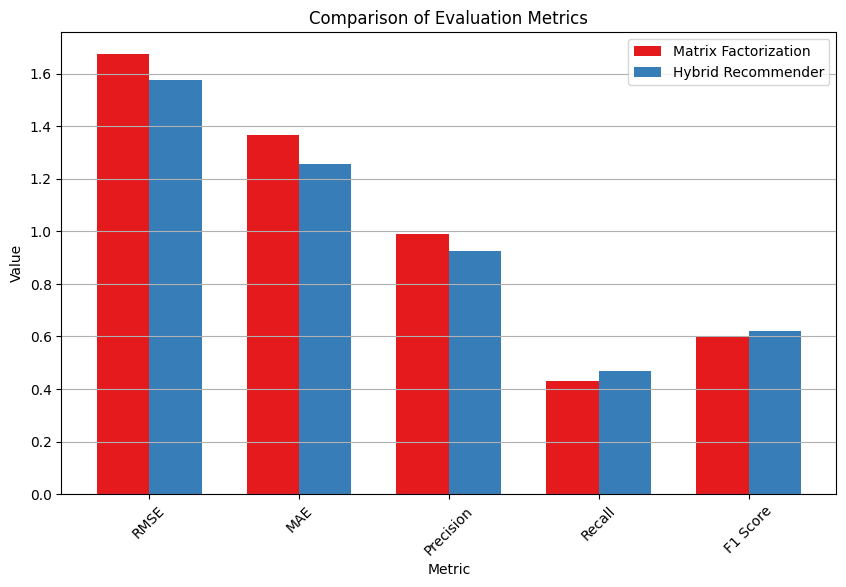

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data from the image
metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'F1 Score']
matrix_factorization_values = [1.6743, 1.3665, 0.9895, 0.4292, 0.5987]
hybrid_recommender_values = [1.5738, 1.2543, 0.9251, 0.4679, 0.6218]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data as bars
bar_width = 0.35  # Adjust bar width as needed
index = range(len(metrics))  # Create index for bar positions

# Use a vibrant colormap (e.g., Set1)
cmap = cm.get_cmap('Set1')

# Assign colors based on the colormap
bar1_color = cmap(0)
bar2_color = cmap(1)

plt.bar(index, matrix_factorization_values, bar_width, label='Matrix Factorization', color=bar1_color)
plt.bar([i + bar_width for i in index], hybrid_recommender_values, bar_width, label='Hybrid Recommender', color=bar2_color)

# Customize the plot
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of Evaluation Metrics')
plt.xticks([i + bar_width / 2 for i in index], metrics, rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(axis='y')  # Add grid lines on the y-axis

# Display the plot
plt.show()
